# Library Inport

In [1]:
import copy
import json
import numpy as np

import torch
import torch.nn as nn

import networkx as nx
from networkx.readwrite import json_graph

import torch_geometric
from torch_geometric.utils.convert import from_networkx,to_networkx
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn.models import GIN,GCN,GAT,GraphSAGE
from torch_geometric.nn.conv import GCNConv,SAGEConv,GINConv,GATConv
from torch_geometric.explain.metric import groundtruth_metrics

import matplotlib.pyplot as plt

# Classi ausiliarie di utilità
Classe che permette di estrarre i grafi salvati su file e rappresentarli in formato Data in manniera opportuna, oltre a permettere di estrarre le maschere per training e test set.

In [2]:
class DatasetCreator():
    def __init__(self,paths,node_attrs,edge_attrs,label):
        '''
        Args:
            paths (list[str]): Paths ai file contenenti i grafi
            node_attrs (list[str]): Attributi dei nodi
            edge_attrs (list[str]): Attributi degli archi
            label (str): Etichette ground truth
        '''
        self.node_attrs=node_attrs
        self.edge_attrs=edge_attrs
        self.label=label
        self.data=self._read_from_json_(paths)
        self._set_masks_()
    
    def _read_from_json_(self,paths):
        '''
        Estrai i grafi contenuti in una lista di file.
        Args:
            paths (list[str]): Paths ai file contenenti i grafi
        Returns:
            GS (list[torch_geometric.Data]): Grafi contenuti nei files
        '''
        GS = []
        for path in paths:
            json_gs= None
            with open(path,'r') as file:
                json_gs = json.load(file)
                file.close()
            for g in json_gs:
                GS.append(json_graph.node_link_graph(g))
        return self._prepair_data_(GS)
    
    def _prepair_data_(self,GS):
        '''
        Trasforma i grafi in formato pytorch_geometric andando a specificare le feature dei nodi,
        degli archi e le etichette ground truth.
        Args:
            GS (list[nx.Graph]): Grafi formato Networkx
        Returns:
            datas (list[torch_geometric.Data]): Grafi in formato Data pytorch_geometric
        '''
        datas = []
        for g in GS:
            tmp = from_networkx(g,group_node_attrs=self.node_attrs)
            tmp.y = tmp[self.label]
            tmp[self.label] = None
            self._normalize_features_(tmp)
            datas.append(tmp)
        return datas
    
    def _normalize_features_(self,G):
        '''
        Normalizza le feature di un grafo in un range [0,1]
        Args:
            G (torch_geometric.Data)
        '''
        x = G.x
        min_vals = x.min(dim=0, keepdim=True).values
        max_vals = x.max(dim=0, keepdim=True).values
        G.x = (x - min_vals) / (max_vals - min_vals)

    def _set_masks_(self,train_ratio=0.7):
        """
        Assegna le maschere per i nodi associati al training set e al test set,
        bilanciandole rispetto alle classi.

        Args:
            train_ratio (float): Frazione dei nodi da incorporare nel training set (0 < train_ratio < 1).
        """
        for g in self.data:
            num_nodes = g.x.shape[0]  # Numero totale di nodi

            # Creazione delle maschere inizializzate a False
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)

            # Trova le classi presenti nei dati
            classes = torch.unique(g.y)  # `g.y` contiene le etichette delle classi

            for cls in classes:
                # Indici dei nodi appartenenti alla classe corrente
                class_indices = torch.nonzero(g.y == cls, as_tuple=True)[0]

                # Mescola casualmente gli indici di questa classe
                shuffled_indices = class_indices[torch.randperm(len(class_indices))]

                # Numero di nodi da assegnare al training set per questa classe
                num_train = int(len(class_indices) * train_ratio)

                # Assegna i nodi ai set di training e test
                train_mask[shuffled_indices[:num_train]] = True
                test_mask[shuffled_indices[num_train:]] = True

            # Assegna le maschere al grafo
            g.train_mask = train_mask
            g.test_mask = test_mask
        
    def get_masks(self,g):
        '''
        Restituisci le maschere per i nodi associati al training set e al test set
        Args:
            g (int): index of the graph in data list
        Returns:
            masks (tuple(Tensor,Tensor)): tupla contenente le maschere per esempi del train e test set
        '''
        G = self.data[g]
        return G.train_mask,G.test_mask

    def get_graph_info(self,idx):
        '''
        Restituisce informazioni relative al grafo in formato pytorch_geometric
        Args:
            G (torch_geometric.Data): un grafo formato pythorch_geometric
        '''
        print(f'Number of nodes: {self.data[idx].num_nodes}') #Number of nodes in the graph
        print(f'Number of edges: {self.data[idx].num_edges}') #Number of edges in the graph
        print(f'Average node degree: {self.data[idx].num_edges / self.data[idx].num_nodes:.2f}') # Average number of nodes in the graph
        print(f'Contains isolated nodes: {self.data[idx].has_isolated_nodes()}') #Does the graph contains nodes that are not connected
        print(f'Contains self-loops: {self.data[idx].has_self_loops()}') #Does the graph contains nodes that are linked to themselves
        print(f'Is undirected: {self.data[idx].is_undirected()}') #Is the graph an undirected graph

    def get_data(self):
        '''
        Restituisce i grafi formato pytorch_geometric.
        Returns:
            _ (torch_geometric.Data): grafo
        '''
        return self.data

Classe ausiliaria per il training e l'evaluation del modello.

In [3]:
class Trainer:
    def __init__(self,model,train_set,criterion,optimizer,metrics):
        '''
        Args:
            model (torch_geometric.nn.model): modello da addestrare
            train_set (torch_geometric.Data): dataset su cui viene effettuato il training
            criterion (torch._Loss) : loss
            optimizer (torch.optim): ottimizzatore
            scheduler (torch.optim.LRscheduler): scheduler learning rate
            metrics (list[str]): lista delle stringhe delle metriche da valutare nella fase di testing
        '''
        self.model = model
        self.train_set = train_set
        self.criterion = criterion
        self.optimizer = optimizer
        self.metrics = metrics
    
    def train(self,num_epocs):
        """
        Main loop per l'addestramento del modello.
        Args:
            num_epocs (int): numero di epoche totali
        """
        self.model.train()
        self.optimizer.zero_grad()
        prev_loss = 0
        no_variation = False #per verificare se c'è stata una variazione consecutiva sotto la soglia per l'early stop
        for epoc in range(num_epocs):
            print(f'---- EPOCH {epoc} ----')
            losses = []
            for g in self.train_set:
                graph_losses = []
                train_loader = NeighborLoader(g,input_nodes=g.train_mask,num_neighbors=[8],batch_size=16,subgraph_type='induced')
                for batch in train_loader:
                    loss = self._train_step_(batch)
                    graph_losses.append(loss.detach().numpy())
                losses+=graph_losses
            l = np.mean(losses)
            print(f'Epoc {epoc} mean loss {l}')
            if np.abs(l - prev_loss) < 0.005:
                if no_variation:
                    break
                else:
                    no_variation=True
            else:
                no_variation=False
            prev_loss = l
            
    def _train_step_(self,batch):
        """
        Step di addestramento su un batch.
        Args:
            batch (torch_geometric.Data): un grafo del training set
        Returns:
            loss (torch.Tensor): loss del modello sul batch
        """
        out = self.model(batch.x, batch.edge_index,batch.Weight)
        out = nn.LogSoftmax(dim=1)(out)
        loss = self.criterion(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss
        
    def test(self):
        '''
        Loop per la valutazione del modello sul test set.
        '''
        self.model.eval()
        print("----- Testing -----")
        losses = []
        metric_values = []
        for g in self.train_set:
            test_loader = NeighborLoader(g,input_nodes=g.test_mask,num_neighbors=[8],batch_size=16,subgraph_type='induced')
            for batch in test_loader:
                loss,value = self._test_step_(batch)
                losses.append(loss.detach().numpy())
                metric_values.append(value)
        print(f'loss {np.mean(losses)}')
        print(f'{self.metrics}: {np.mean(metric_values)}')

    
    def _test_step_(self,batch):
        """
        Step del test del modello su un batch.
        Args:
            batch (torch_geometric.Data): un grafo del test set
        Returns:
            loss(torch.Tensor): loss del modello sul batch
            metric(Union[float, Tuple[float, ...]]): valori delle metriche per il batch
        """
        out = self.model(batch.x, batch.edge_index,batch.Weight)
        out = nn.LogSoftmax(dim=1)(out)
        predictions = torch.argmax(out, dim=1)
        loss = self.criterion(out[batch.test_mask],batch.y[batch.test_mask])
        metric = groundtruth_metrics(predictions[batch.test_mask], batch.y[batch.test_mask], metrics=self.metrics)
        return loss, metric

Classe ausiliaria che gestisce la valutazione di un modello su un evaluation set.

In [4]:
class Validator:

    def __init__(self,model,eval_set,criterion,metrics):
        '''
        Args:
            model (torch_geometric.nn.model): modello da addestrare
            eval_set (torch_geometric.Data): dataset su cui viene effettuato la valutazione
            criterion (torch._Loss) : loss
            metrics (list[str]): lista delle stringhe delle metriche da valutare
        '''
        self.model = model
        self.eval_set = eval_set
        self.criterion = criterion
        self.metrics = metrics
    
    def eval(self):
        '''
        Loop per la valutazione del modello sul test set.
        '''
        self.model.eval()
        print("----- Evaluating -----")
        i=0
        losses = []
        metric_values = []
        for g in self.eval_set:
            eval_loader = NeighborLoader(g,input_nodes=g.test_mask,num_neighbors=[8],batch_size=16,subgraph_type='induced')
            j = 0
            for batch in eval_loader:
                loss,value = self._eval_step_(batch,i,j)
                losses.append(loss.detach().numpy())
                metric_values.append(value)
                j+=1
            i+=1
        print(f'loss {np.mean(losses)}')
        print(f'{self.metrics}: {np.mean(metric_values)}')

    def _eval_step_(self,batch,i,j):
        """
        Step del test del modello su un batch.
        Args:
            batch (torch_geometric.Data): un grafo del test set
        Returns:
            loss(torch.Tensor): loss del modello sul batch
            metric(Union[float, Tuple[float, ...]]): valori delle metriche per il batch
        """
        out = self.model(batch.x, batch.edge_index,batch.Weight)
        out = nn.LogSoftmax(dim=1)(out)
        predictions = torch.argmax(out, dim=1)
        loss = self.criterion(out[batch.test_mask],batch.y[batch.test_mask])
        metric = groundtruth_metrics(predictions[batch.test_mask], batch.y[batch.test_mask], metrics=self.metrics)
        if(i % 5 == 0 and j == 0):
            Validator.draw_original_vs_predicted(batch,predictions,i,j)
        return loss, metric

    def draw_original_vs_predicted(G,predictions,i,j):
        """
        Rappresenta graficamente il grafo con le etichette originali e quelle predette.
        Args:
            G (torch_geometric.Data): grafo da rappresentare
            predictions (list(int)): etichette predette
            i (int): indice del grafo di cui fa parte il batch
            j (int): indice del batch nell'insieme dei batchs
        """
        graph1 = to_networkx(G,node_attrs=['y'],to_undirected=True)
        graph2 = to_networkx(G,to_undirected=True)
        nx.set_node_attributes(graph2, {i: int(pred) for i, pred in enumerate(predictions.tolist())}, 'y')
        
        g1_labels=nx.get_node_attributes(graph1,'y')
        g2_labels = nx.get_node_attributes(graph2,'y')

        pos = nx.spring_layout(graph1)
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        nx.draw(graph1,pos=pos,ax=axes[0],edgecolors = 'black',node_color='lightblue',with_labels=False)
        nx.draw_networkx_labels(graph1, pos,ax=axes[0], labels=g1_labels, font_size=8, font_color='black')
        axes[0].set_title("Original labels")

        nx.draw(graph2,pos=pos,ax=axes[1],edgecolors = 'black',node_color='lightblue',with_labels=False)
        nx.draw_networkx_labels(graph2, pos,ax=axes[1], labels=g2_labels, font_size=8, font_color='black')
        axes[1].set_title("Predicted labels")
        
        plt.suptitle(f'Original vs Predicted \n Graph {i}, batch {j}',fontsize=10)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

# Funzioni di utilità

Metodo utile per effettuare l'addestramento dei modelli.

In [5]:
def process_model(m,data,epocs):
    '''
    Effettua training e testing di un modello
    Args:
        m (torch_geometric.nn.model): un modello pytorch geometric
        data ([torch_geometric.Data]): dati per addestramento modello
        epocs (int): numero epoche per addestramento
    '''
    m.reset_parameters()
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(m.parameters(),lr=1e-4,weight_decay=1e-4)  # Initialize the Adam optimizer.
    optimizer.zero_grad() # Clear gradients.
    trainer = Trainer(m,data,criterion,optimizer,['f1_score'])

    trainer.train(epocs)
    
    trainer.test()

# Learning senza Attributo Score

## Caricamento dataset

In [6]:
train_set = DatasetCreator(['advanced mixed train.json'],['Likes','Shares','Comments','Visuals','Dislikes'],['Interactions'],'Misinformative')
eval_set = DatasetCreator(['advanced mixed validation.json'],['Likes','Shares','Comments','Visuals','Dislikes'],['Interactions'],'Misinformative')

in_channels = train_set.get_data()[0].num_features

/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


## Addestramento GCN

In [7]:
gcn_model = GCN(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")

process_model(gcn_model,train_set.get_data(),10)

---- EPOCH 0 ----


/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Epoc 0 mean loss 0.6251988410949707
---- EPOCH 1 ----
Epoc 1 mean loss 0.6203678250312805
---- EPOCH 2 ----
Epoc 2 mean loss 0.601007878780365
---- EPOCH 3 ----
Epoc 3 mean loss 0.5794408917427063
---- EPOCH 4 ----
Epoc 4 mean loss 0.5563169121742249
---- EPOCH 5 ----
Epoc 5 mean loss 0.5431873798370361
---- EPOCH 6 ----
Epoc 6 mean loss 0.5330517888069153
---- EPOCH 7 ----
Epoc 7 mean loss 0.5223271250724792
---- EPOCH 8 ----
Epoc 8 mean loss 0.516761839389801
---- EPOCH 9 ----
Epoc 9 mean loss 0.5121763348579407
----- Testing -----


/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


loss 0.4504315257072449
['f1_score']: 0.6416120379359895


----- Evaluating -----


/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


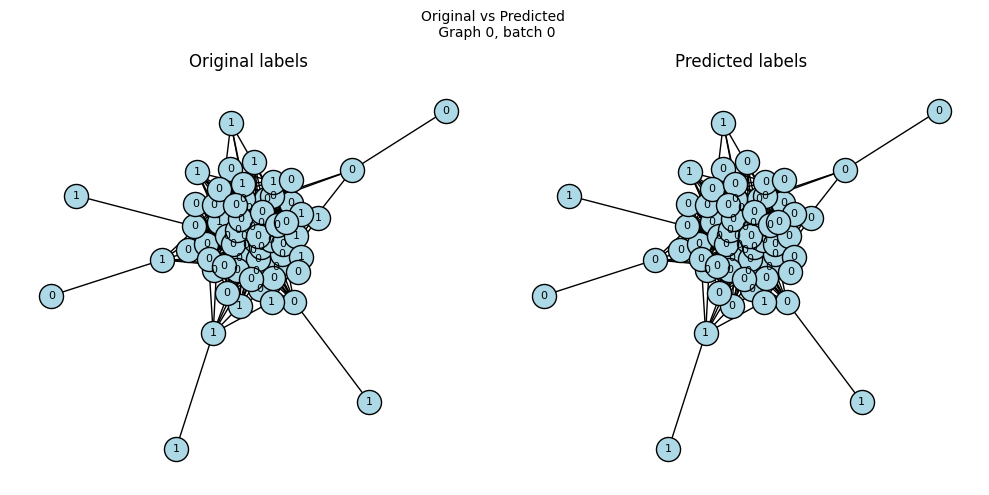

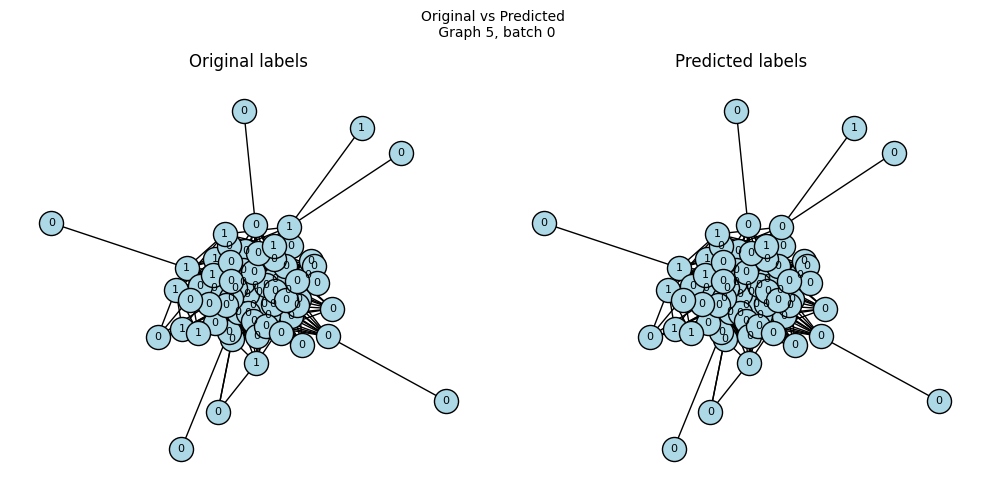

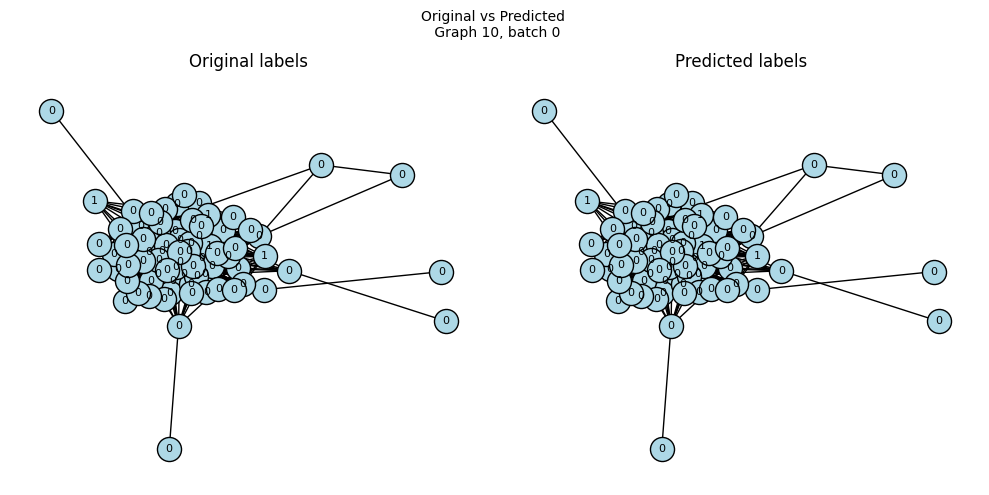

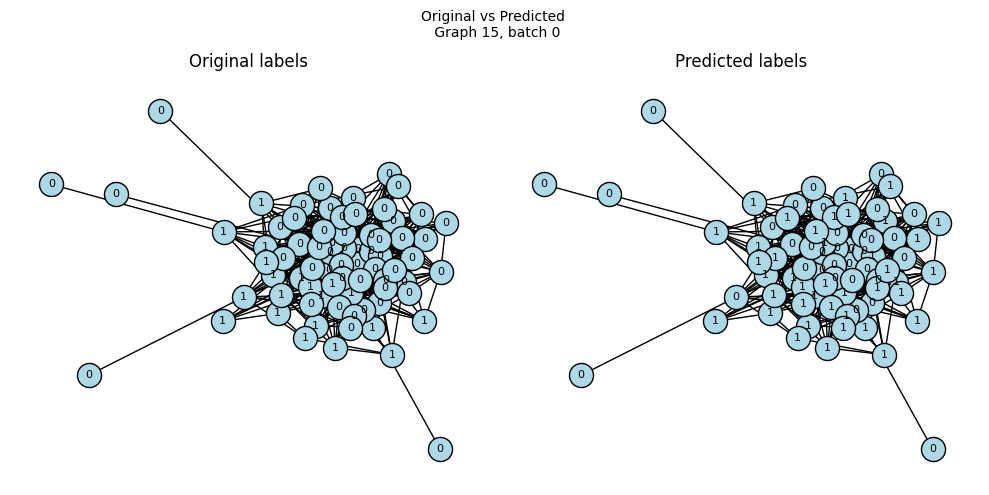

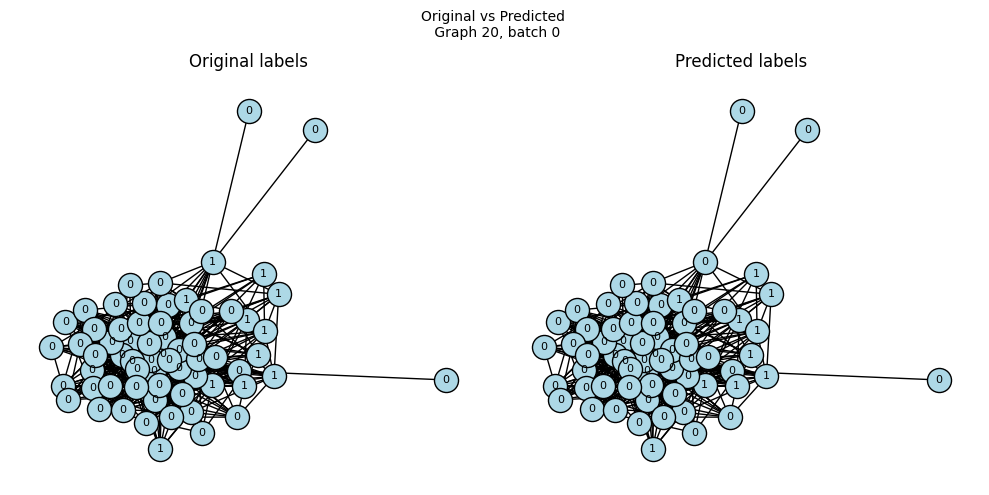

loss 0.4119585454463959
['f1_score']: 0.6385863768421692


In [8]:
eval = Validator(gcn_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

## Addestramento GAT

In [9]:
gat_model = GAT(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")
process_model(gat_model,train_set.get_data(),10)

---- EPOCH 0 ----
Epoc 0 mean loss 0.6063969731330872
---- EPOCH 1 ----
Epoc 1 mean loss 0.5675535798072815
---- EPOCH 2 ----
Epoc 2 mean loss 0.5246907472610474
---- EPOCH 3 ----
Epoc 3 mean loss 0.4914674758911133
---- EPOCH 4 ----
Epoc 4 mean loss 0.480252206325531
---- EPOCH 5 ----
Epoc 5 mean loss 0.47327908873558044
---- EPOCH 6 ----
Epoc 6 mean loss 0.4654256999492645
---- EPOCH 7 ----
Epoc 7 mean loss 0.46320828795433044
---- EPOCH 8 ----
Epoc 8 mean loss 0.46793028712272644
----- Testing -----
loss 0.4019143581390381
['f1_score']: 0.36370800129103475


----- Evaluating -----


/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


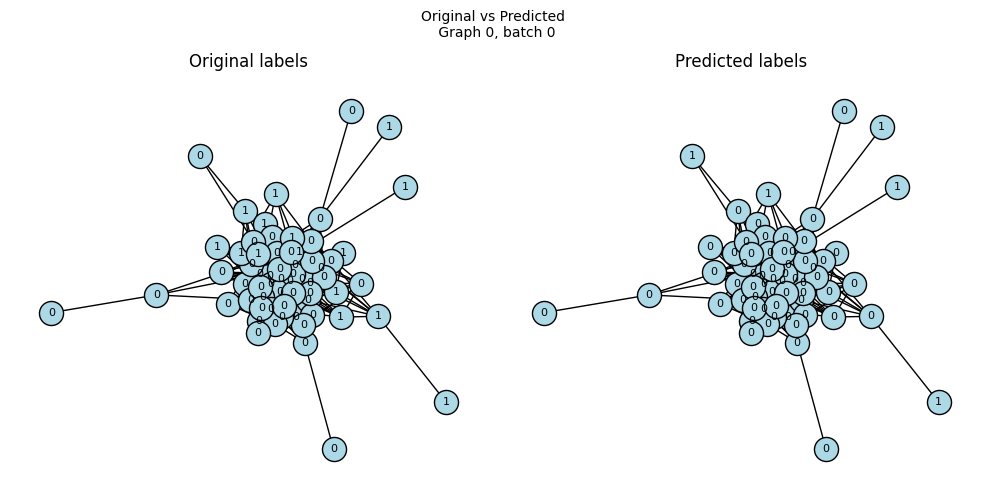

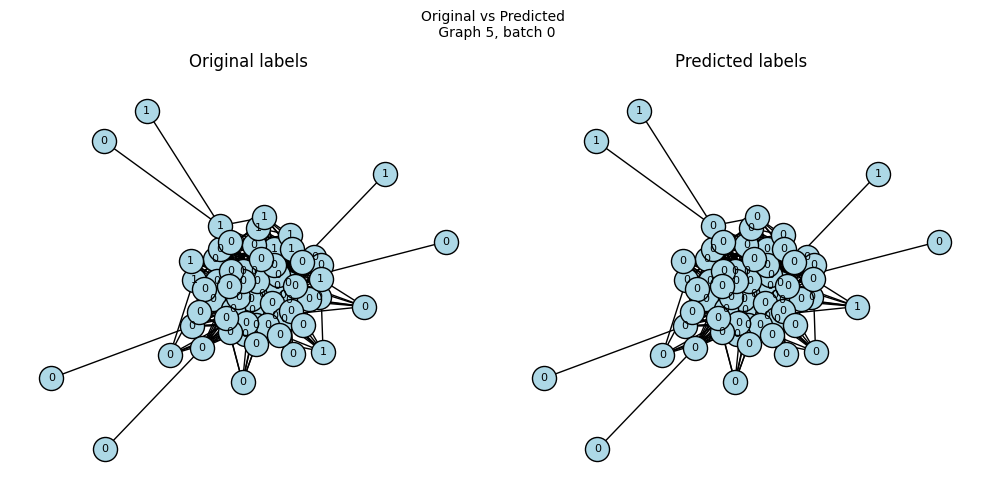

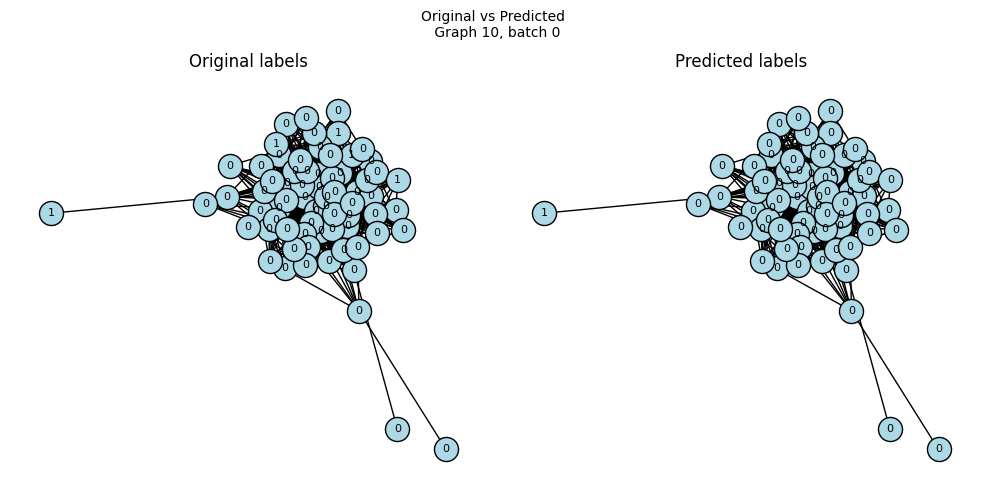

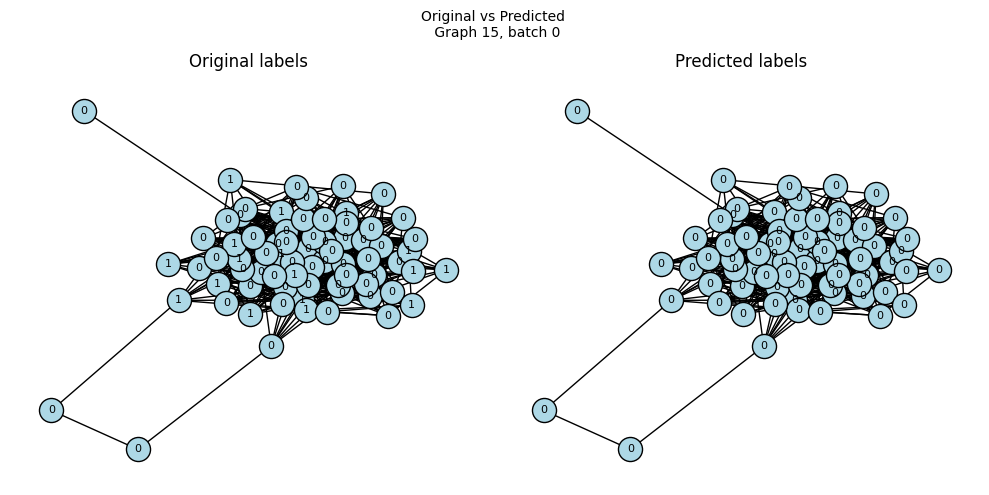

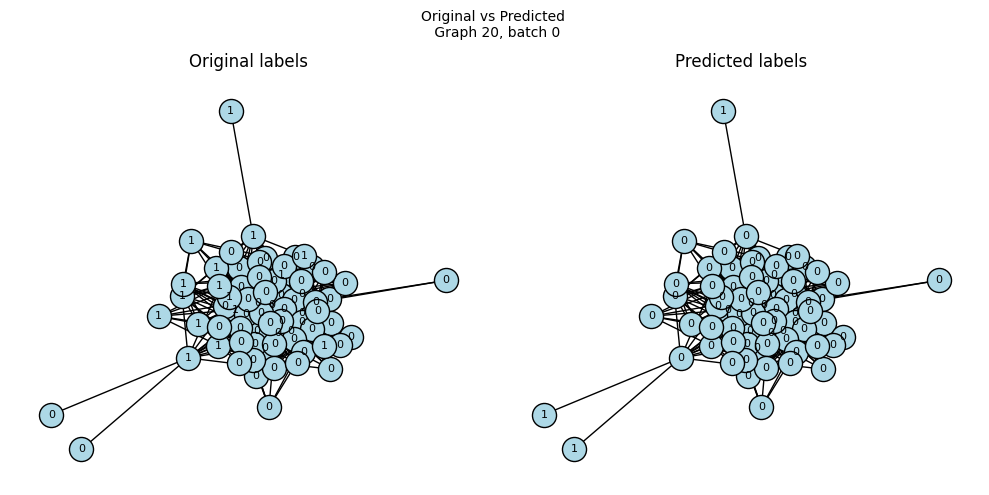

loss 0.45888516306877136
['f1_score']: 0.23100292882639625


In [10]:
eval = Validator(gat_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

## Addestramento GraphSAGE

In [11]:
graphSage_model = GraphSAGE(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")

process_model(graphSage_model,train_set.get_data(),10)

---- EPOCH 0 ----
Epoc 0 mean loss 0.16632355749607086
---- EPOCH 1 ----
Epoc 1 mean loss 0.0642329603433609
---- EPOCH 2 ----
Epoc 2 mean loss 0.04105779901146889
---- EPOCH 3 ----
Epoc 3 mean loss 0.029775433242321014
---- EPOCH 4 ----
Epoc 4 mean loss 0.032272614538669586
---- EPOCH 5 ----
Epoc 5 mean loss 0.03573423996567726
----- Testing -----
loss 0.008669048547744751
['f1_score']: 0.9482294392334542


----- Evaluating -----


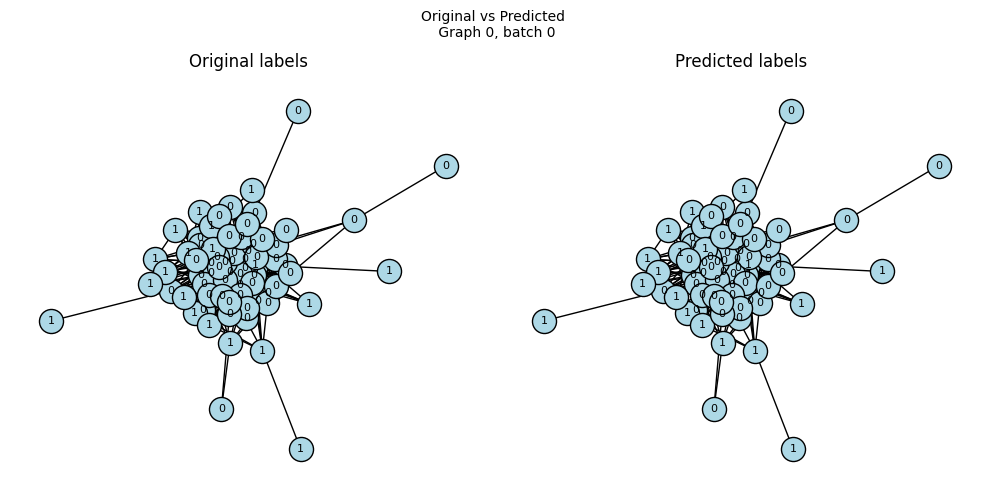

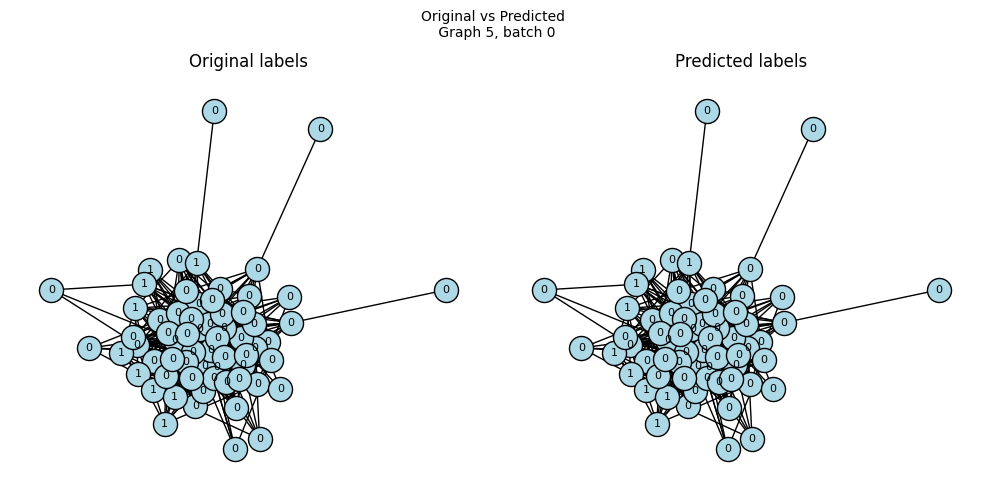

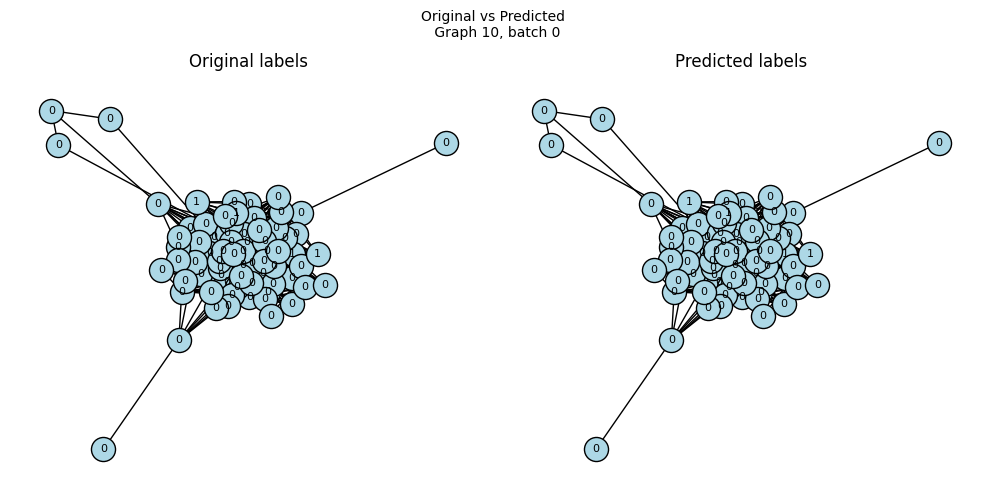

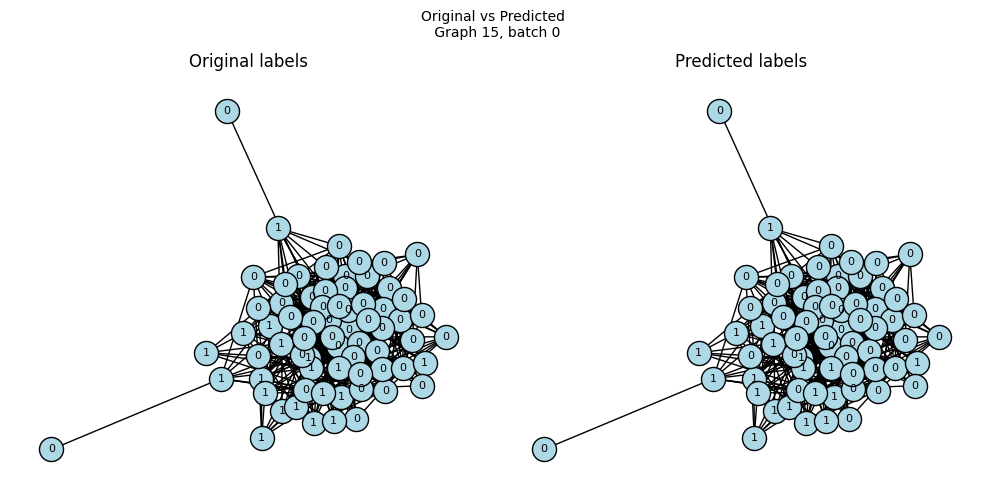

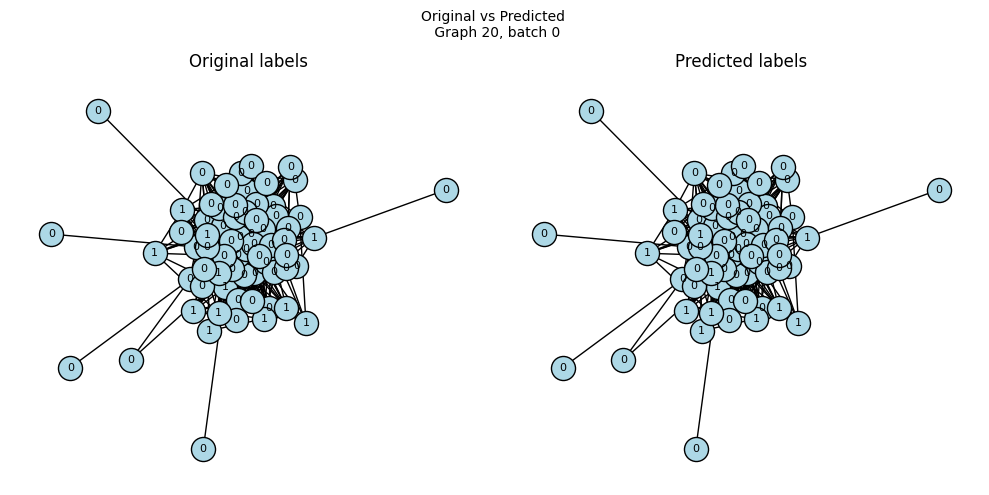

loss 0.0046759978868067265
['f1_score']: 0.9778362182123262


In [12]:
eval = Validator(graphSage_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

## Addestramento GIN

In [13]:
GIN_model = GIN(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")
process_model(GIN_model,train_set.get_data(),10)

---- EPOCH 0 ----
Epoc 0 mean loss 0.25078442692756653
---- EPOCH 1 ----
Epoc 1 mean loss 0.1956748366355896
---- EPOCH 2 ----
Epoc 2 mean loss 0.17217886447906494
---- EPOCH 3 ----
Epoc 3 mean loss 0.17832964658737183
---- EPOCH 4 ----
Epoc 4 mean loss 0.17255066335201263
---- EPOCH 5 ----
Epoc 5 mean loss 0.15911898016929626
---- EPOCH 6 ----
Epoc 6 mean loss 0.16002172231674194
---- EPOCH 7 ----
Epoc 7 mean loss 0.15670816600322723
----- Testing -----
loss 0.15159906446933746
['f1_score']: 0.8538597279050951


----- Evaluating -----


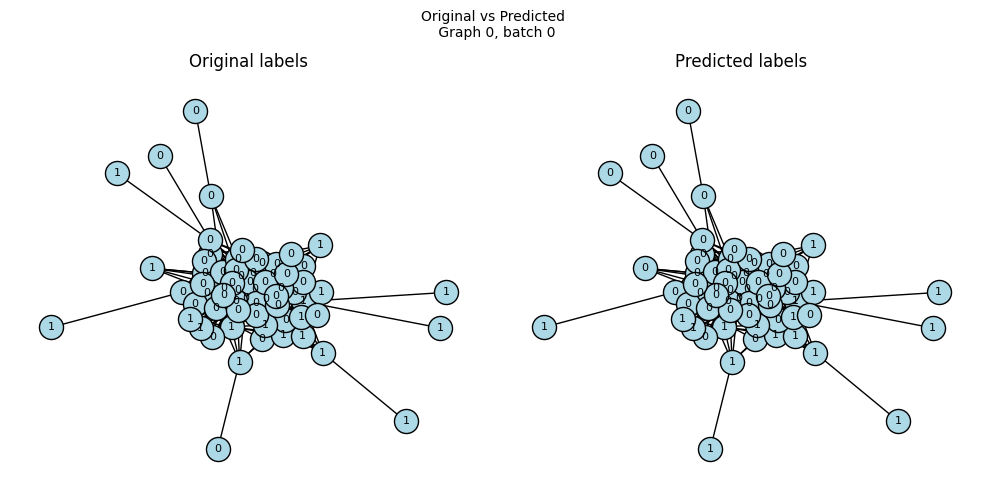

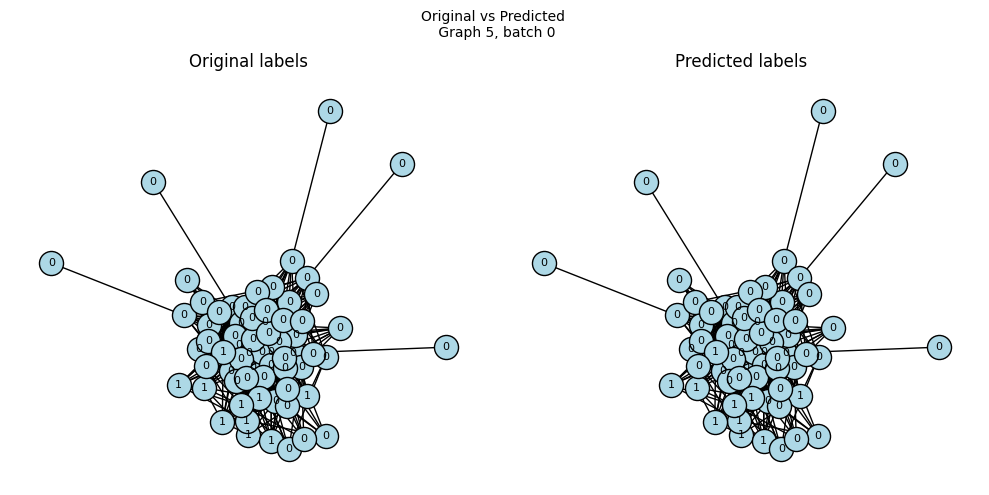

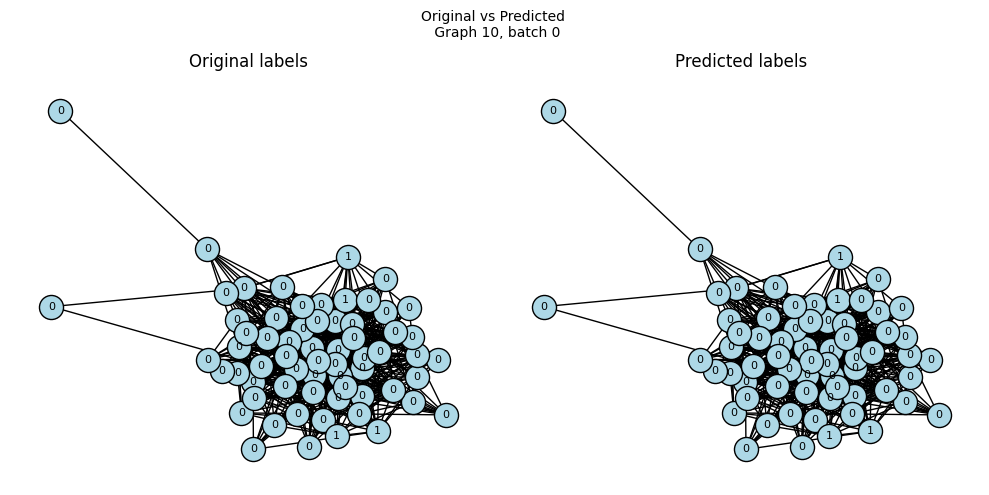

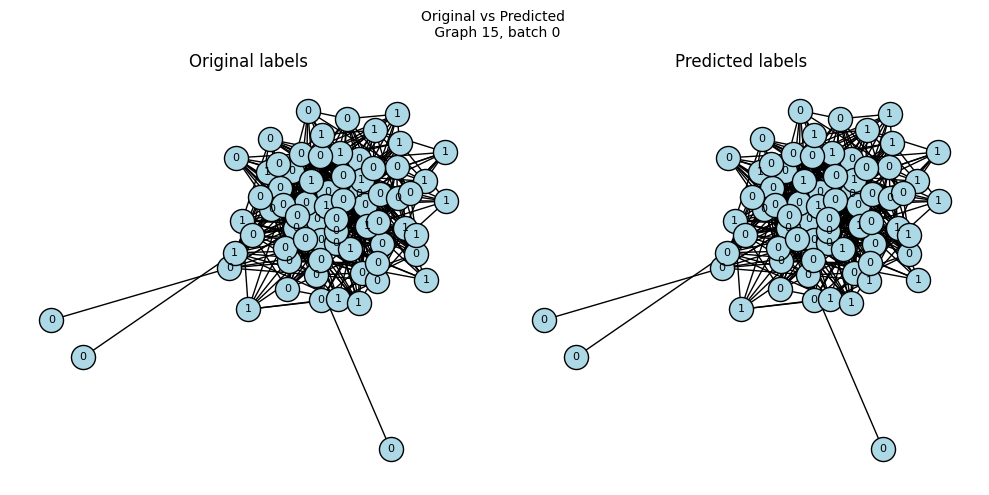

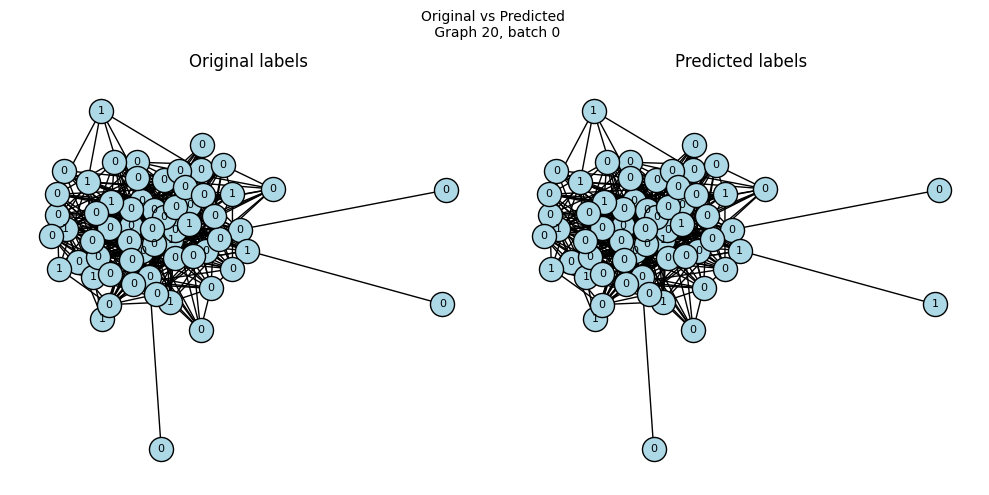

loss 0.1276768445968628
['f1_score']: 0.9112112977723966


In [14]:
eval = Validator(GIN_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

# Learning con Attributo Score

## Caricamento dataset

In [15]:
train_set = DatasetCreator(['advanced mixed train.json'],['Score','Likes','Shares','Comments','Visuals','Dislikes'],['Interactions'],'Misinformative')
eval_set = DatasetCreator(['advanced mixed validation.json'],['Score','Likes','Shares','Comments','Visuals','Dislikes'],['Interactions'],'Misinformative')

in_channels = train_set.get_data()[0].num_features

/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


## Addestramento GCN

In [16]:
GCN_model = GCN(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")

process_model(GCN_model,train_set.get_data(),10)

---- EPOCH 0 ----
Epoc 0 mean loss 0.45409083366394043
---- EPOCH 1 ----
Epoc 1 mean loss 0.2554643154144287
---- EPOCH 2 ----
Epoc 2 mean loss 0.2428320199251175
---- EPOCH 3 ----
Epoc 3 mean loss 0.3980182707309723
---- EPOCH 4 ----
Epoc 4 mean loss 0.35957467555999756
---- EPOCH 5 ----
Epoc 5 mean loss 0.2678610384464264
---- EPOCH 6 ----
Epoc 6 mean loss 0.25499624013900757
---- EPOCH 7 ----
Epoc 7 mean loss 0.23015417158603668
---- EPOCH 8 ----
Epoc 8 mean loss 0.22333510220050812
---- EPOCH 9 ----
Epoc 9 mean loss 0.2462339848279953
----- Testing -----
loss 0.18264952301979065
['f1_score']: 0.8840609007560427


----- Evaluating -----


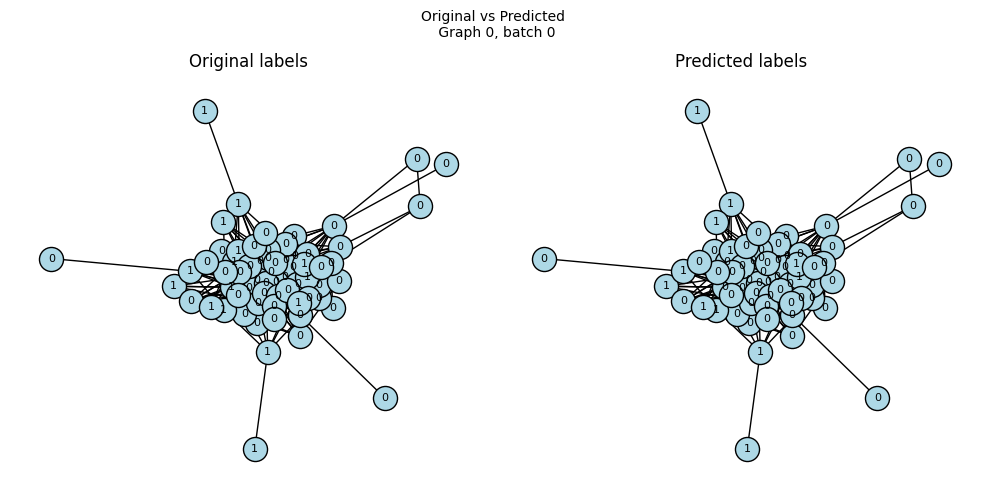

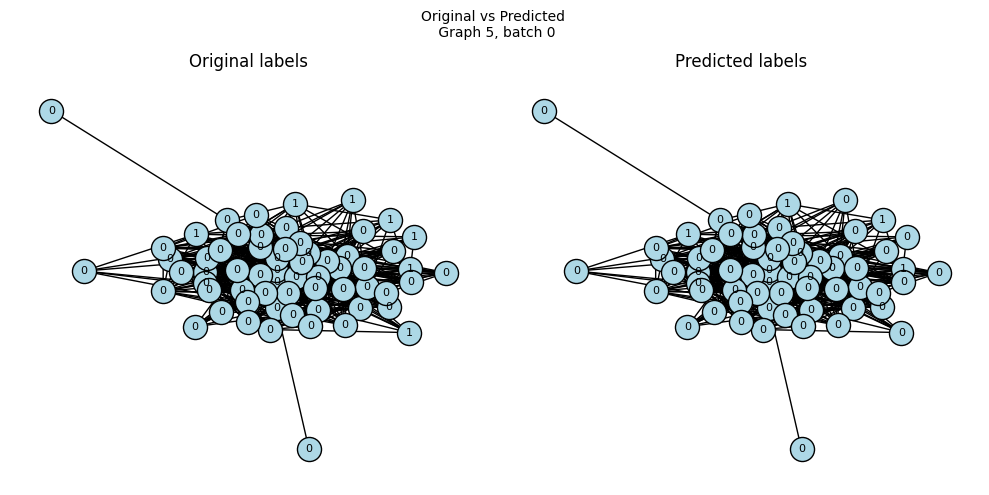

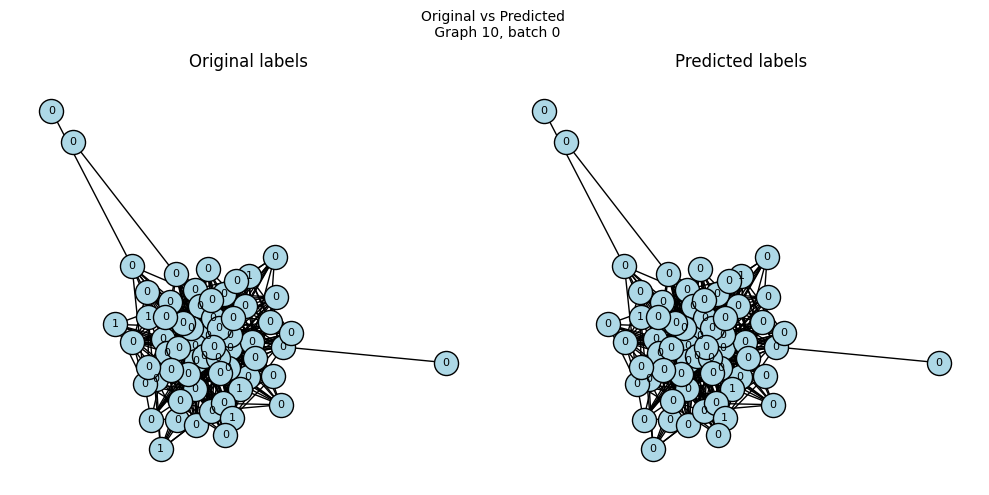

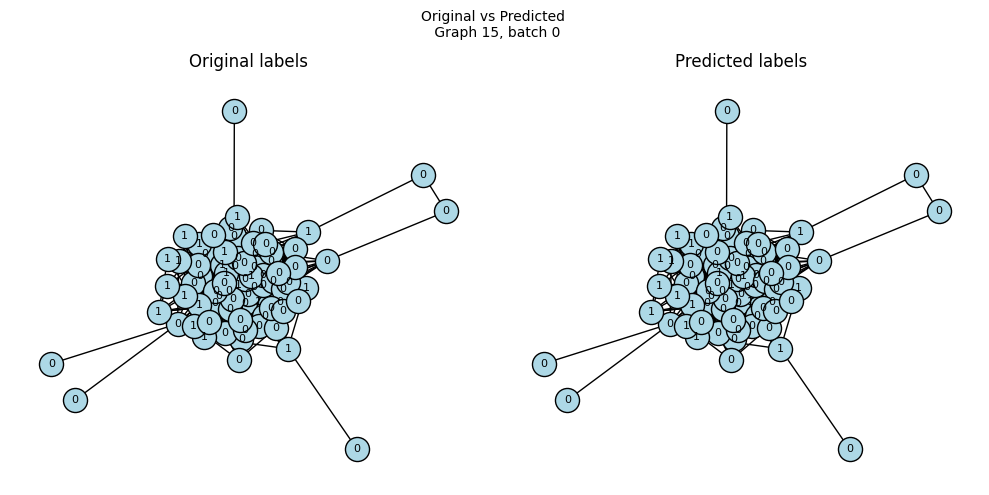

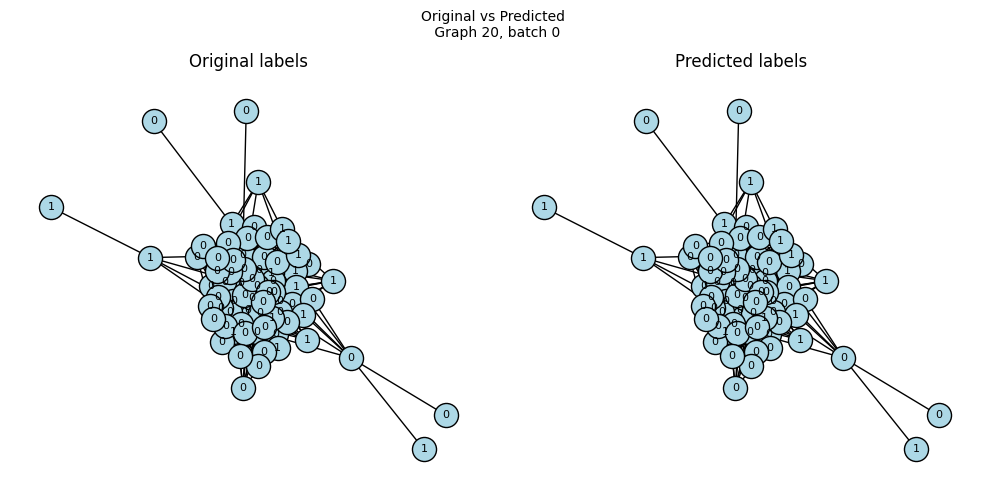

loss 0.11597374081611633
['f1_score']: 0.9382408855935058


In [17]:
eval = Validator(GCN_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

## Addestramento GAT

In [18]:
GAT_model = GAT(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")
process_model(GAT_model,train_set.get_data(),10)

---- EPOCH 0 ----


Epoc 0 mean loss 0.521636962890625
---- EPOCH 1 ----
Epoc 1 mean loss 0.4350608289241791
---- EPOCH 2 ----
Epoc 2 mean loss 0.40340733528137207
---- EPOCH 3 ----
Epoc 3 mean loss 0.4006546437740326
---- EPOCH 4 ----
Epoc 4 mean loss 0.4123585522174835
---- EPOCH 5 ----
Epoc 5 mean loss 0.3895849287509918
---- EPOCH 6 ----
Epoc 6 mean loss 0.41187986731529236
---- EPOCH 7 ----
Epoc 7 mean loss 0.4568701982498169
---- EPOCH 8 ----
Epoc 8 mean loss 0.4393467605113983
---- EPOCH 9 ----
Epoc 9 mean loss 0.48569658398628235
----- Testing -----
loss 0.38494178652763367
['f1_score']: 0.6466795683894795


----- Evaluating -----


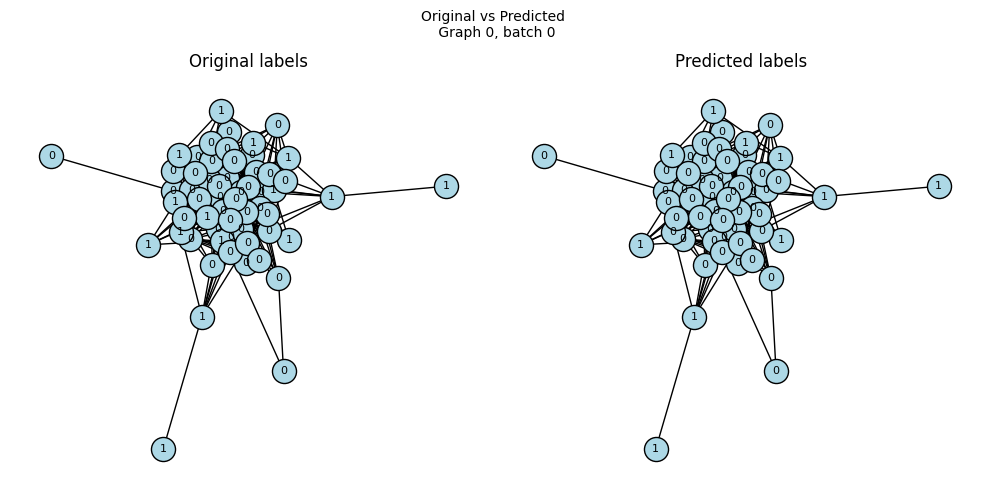

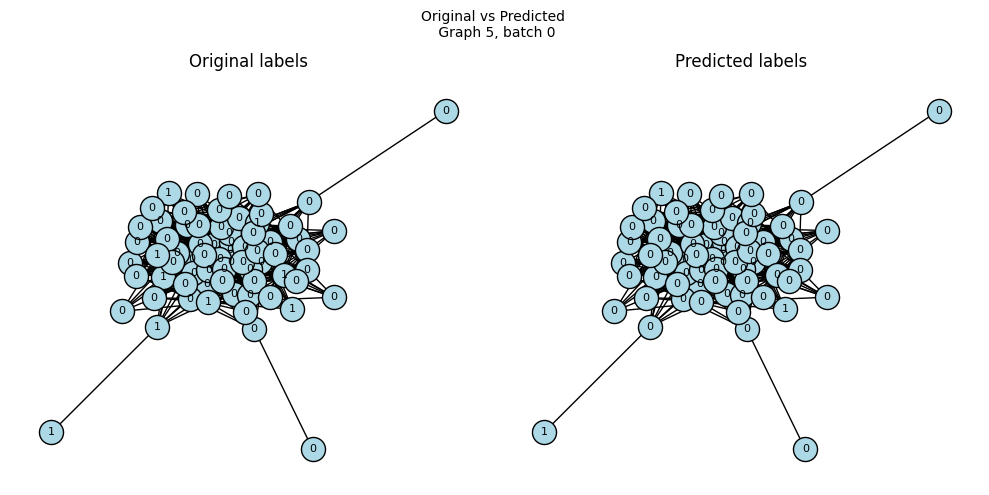

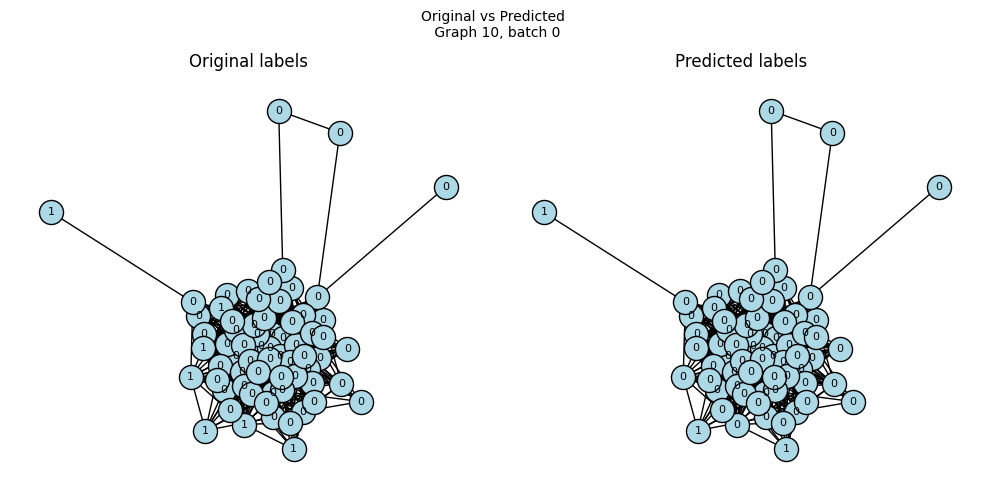

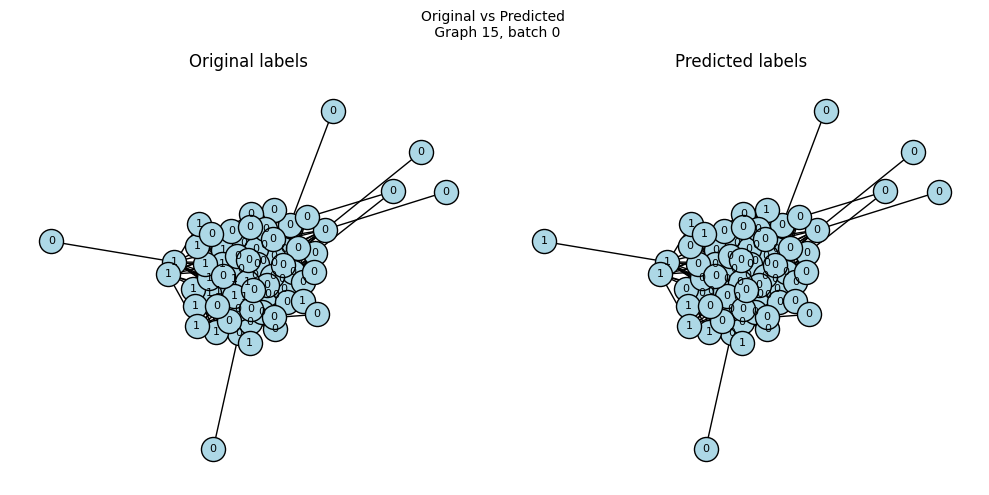

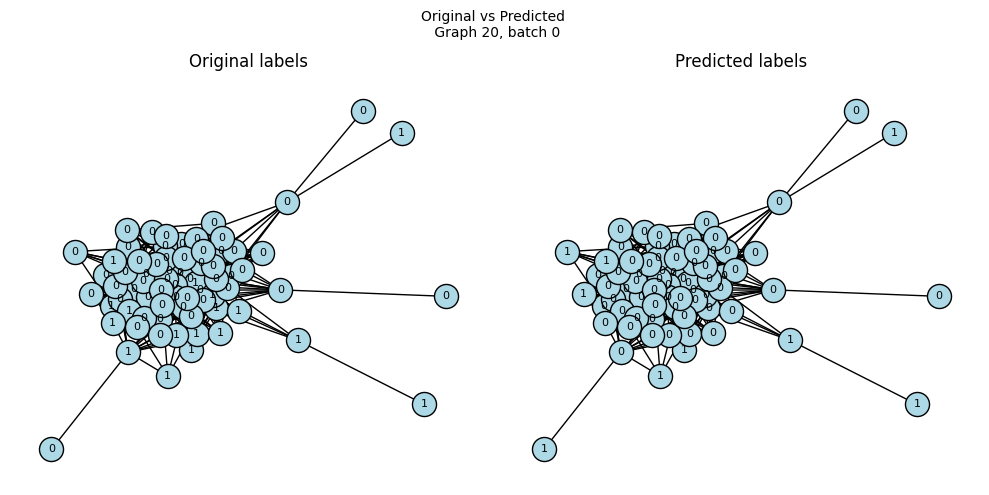

loss 0.4440808594226837
['f1_score']: 0.5646679841833311


In [19]:
eval = Validator(GAT_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

## Addestramento GraphSAGE

In [20]:
GraphSAGE_model = GraphSAGE(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")

process_model(GraphSAGE_model,train_set.get_data(),10)

---- EPOCH 0 ----
Epoc 0 mean loss 0.06699221581220627
---- EPOCH 1 ----
Epoc 1 mean loss 0.028466656804084778
---- EPOCH 2 ----
Epoc 2 mean loss 0.01646946370601654
---- EPOCH 3 ----
Epoc 3 mean loss 0.014959100633859634
---- EPOCH 4 ----
Epoc 4 mean loss 0.018483556807041168
----- Testing -----
loss 0.00014592740626540035
['f1_score']: 0.9513363507529504


----- Evaluating -----


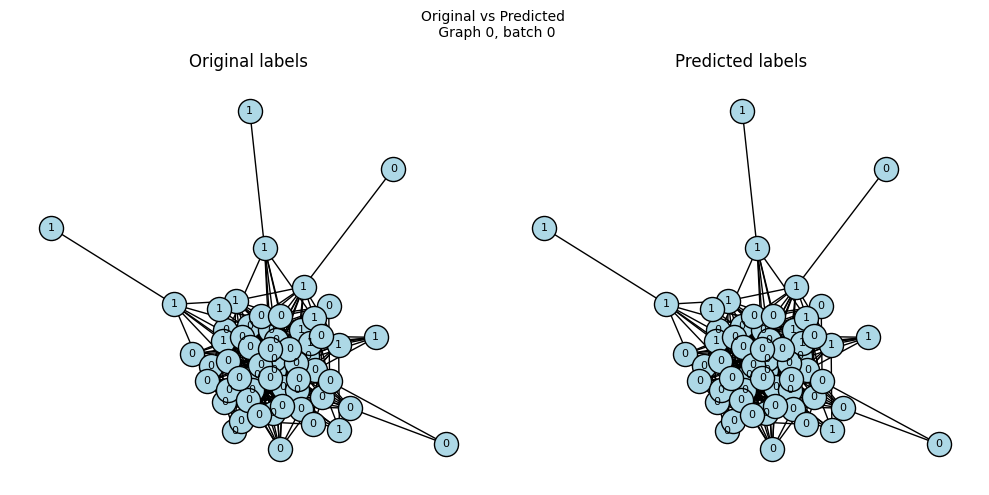

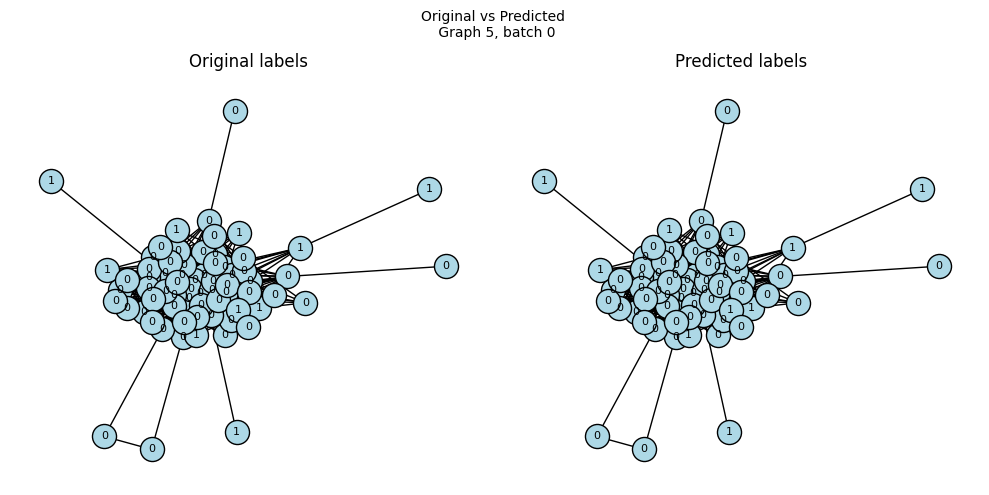

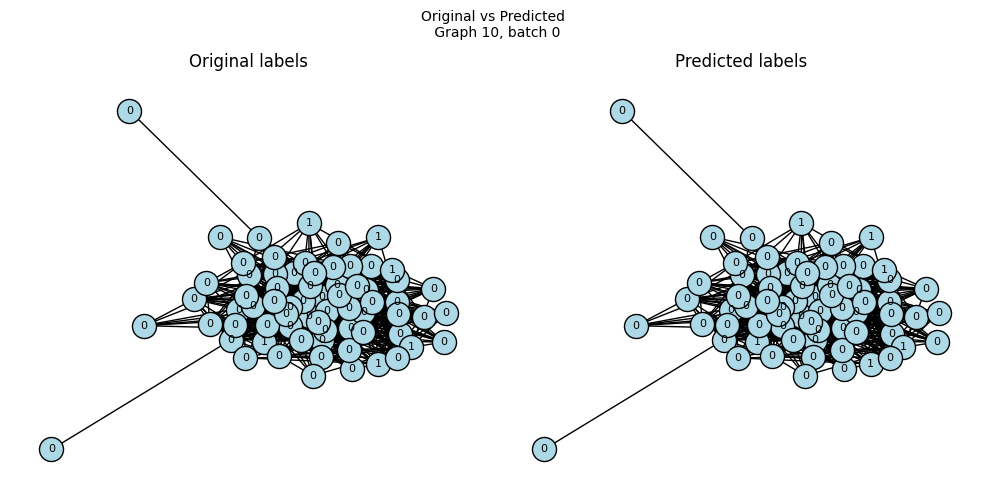

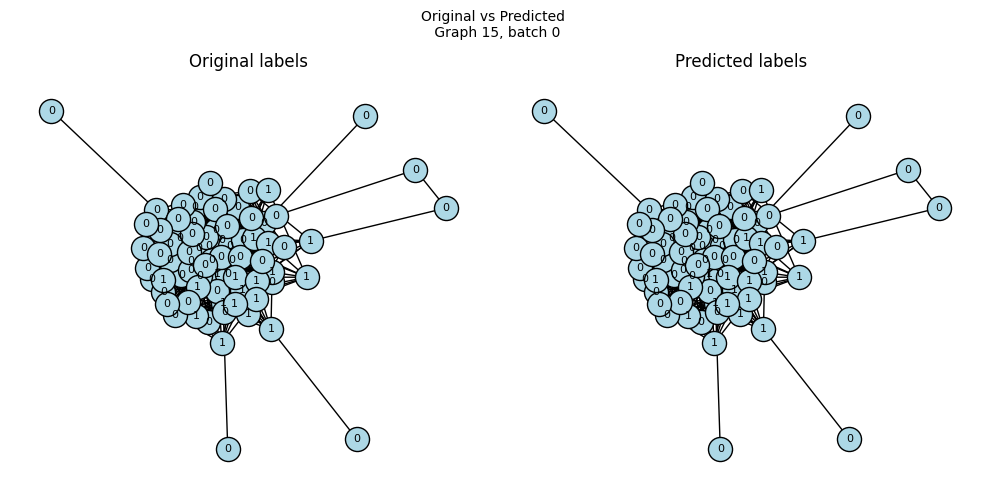

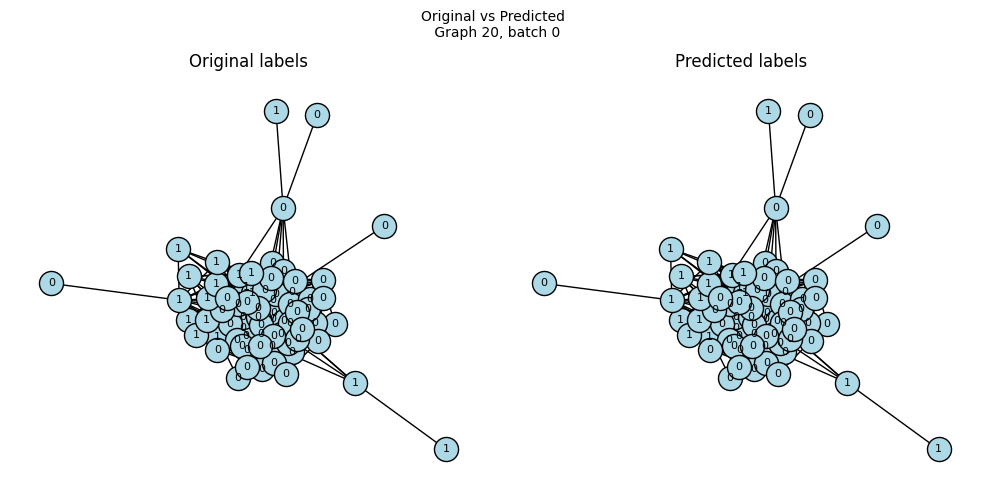

loss 0.0
['f1_score']: 0.9770114942528736


In [21]:
eval = Validator(GraphSAGE_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()

## Addestramento GIN

In [22]:
GIN_model = GIN(in_channels=in_channels,hidden_channels=4,num_layers=2,out_channels=2,dropout=0.2,norm="layer",act_first=True,aggr="mean")
process_model(GIN_model,train_set.get_data(),10)

---- EPOCH 0 ----
Epoc 0 mean loss 0.18840454518795013
---- EPOCH 1 ----
Epoc 1 mean loss 0.1280709058046341
---- EPOCH 2 ----
Epoc 2 mean loss 0.12093577533960342
---- EPOCH 3 ----
Epoc 3 mean loss 0.11605507135391235
---- EPOCH 4 ----
Epoc 4 mean loss 0.1272575408220291
---- EPOCH 5 ----
Epoc 5 mean loss 0.12405043095350266
---- EPOCH 6 ----
Epoc 6 mean loss 0.12873786687850952
----- Testing -----
loss 0.10908158123493195
['f1_score']: 0.9003589805092365


----- Evaluating -----


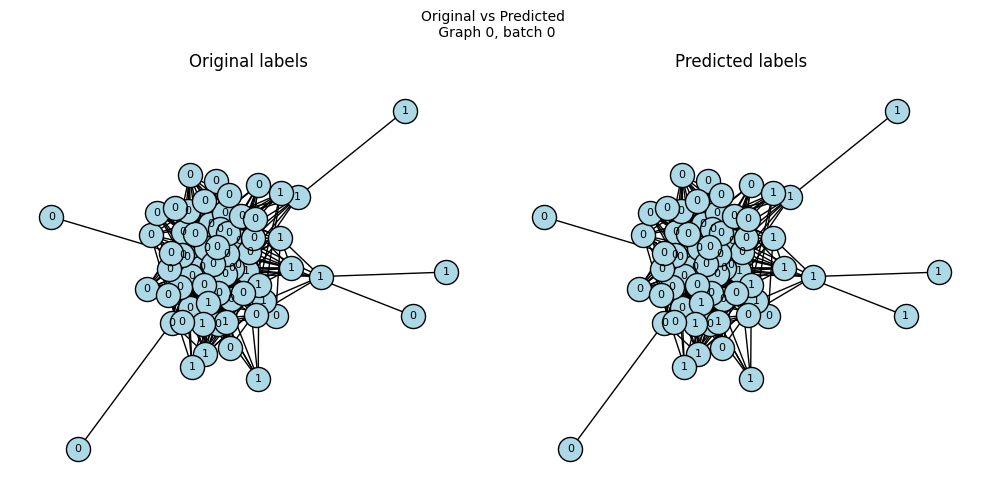

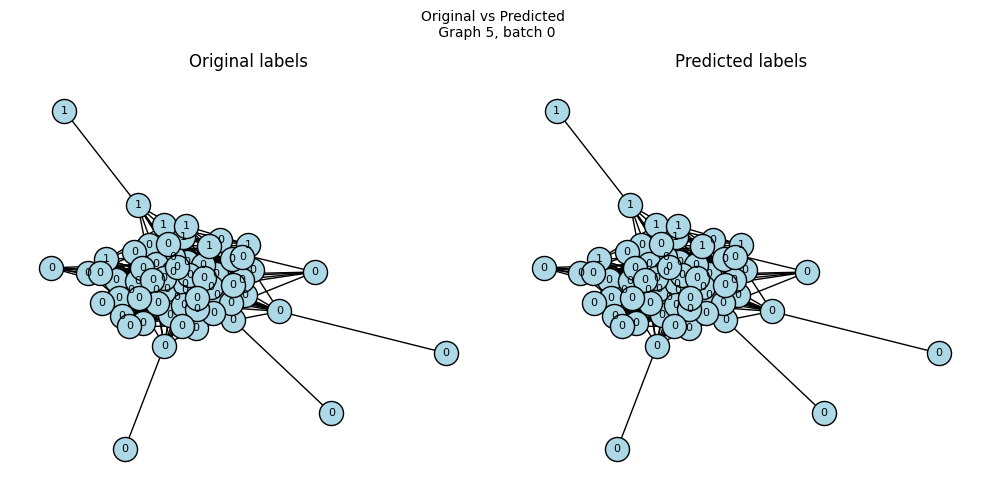

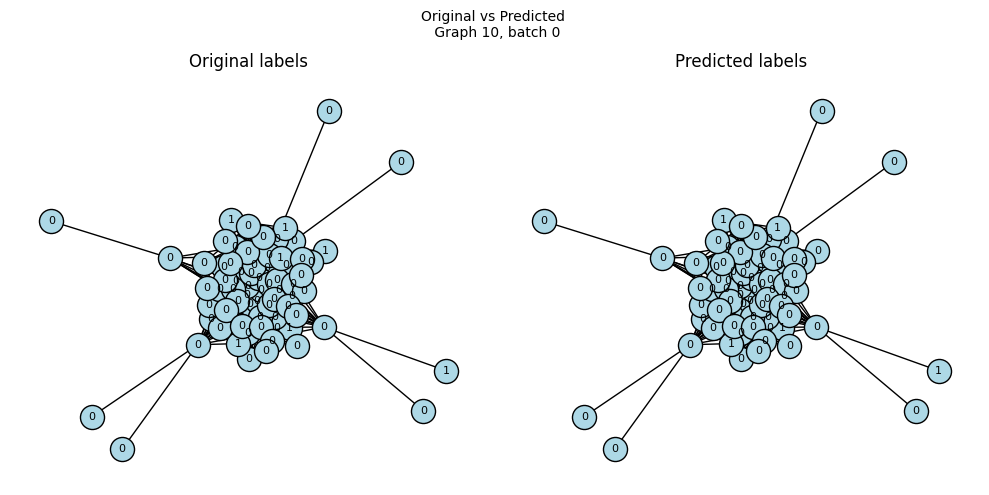

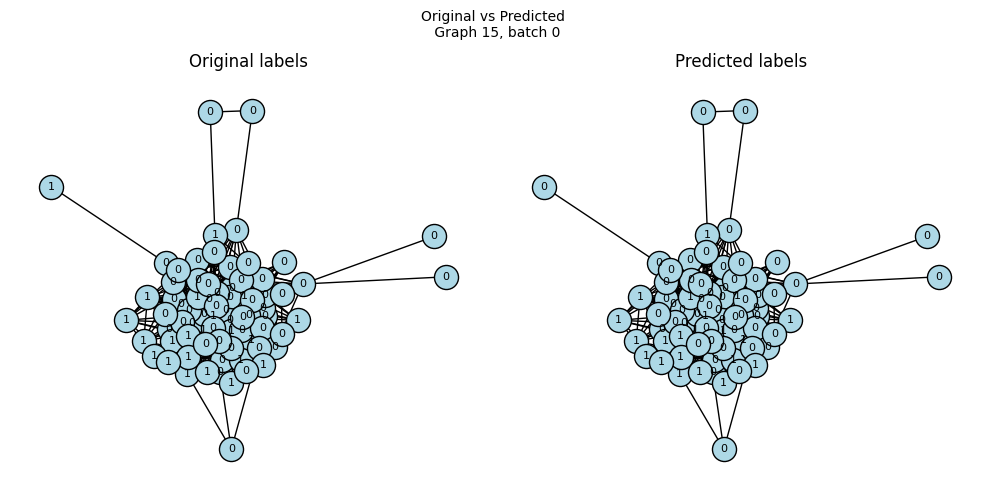

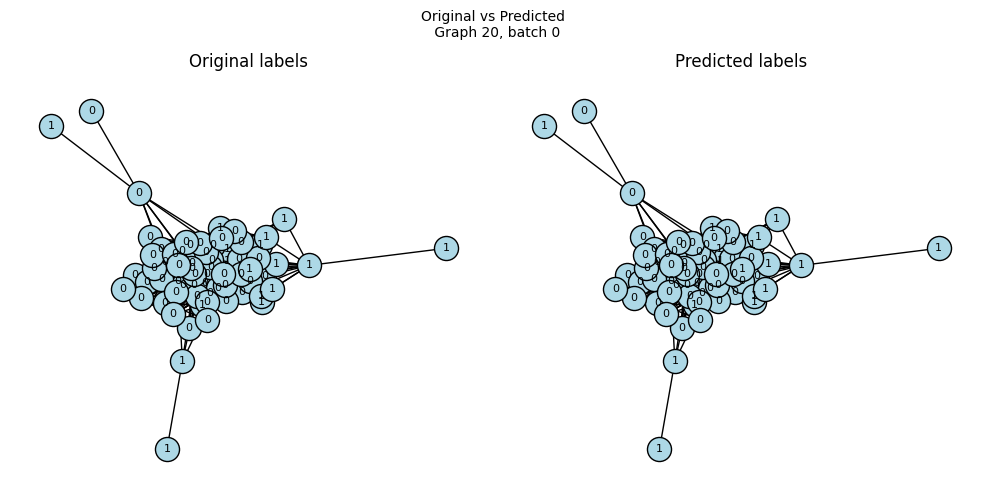

loss 0.08837539702653885
['f1_score']: 0.9406263987666614


In [23]:
eval = Validator(GIN_model,eval_set.get_data(),nn.NLLLoss(),['f1_score'])
eval.eval()